In [3]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [4]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_BPHTB.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2012-1,167193000,2012-01-01
1,2012-2,170000000,2012-02-01
2,2012-3,159210200,2012-03-01
3,2012-4,167193000,2012-04-01
4,2012-5,19000000,2012-05-01


In [7]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/bphtb.json', 'w') as f:
    json.dump(json_data, f) 

{"2012-01-01T00:00:00.000":167193000,"2012-02-01T00:00:00.000":170000000,"2012-03-01T00:00:00.000":159210200,"2012-04-01T00:00:00.000":167193000,"2012-05-01T00:00:00.000":19000000,"2012-06-01T00:00:00.000":102125000,"2012-07-01T00:00:00.000":106719300,"2012-08-01T00:00:00.000":1034675000,"2012-09-01T00:00:00.000":4586325000,"2012-10-01T00:00:00.000":4305746000,"2012-11-01T00:00:00.000":1203830000,"2012-12-01T00:00:00.000":2506501000,"2013-01-01T00:00:00.000":108512950,"2013-02-01T00:00:00.000":118797500,"2013-03-01T00:00:00.000":121135200,"2013-04-01T00:00:00.000":178512950,"2013-05-01T00:00:00.000":12621200,"2013-06-01T00:00:00.000":122000000,"2013-07-01T00:00:00.000":130023000,"2013-08-01T00:00:00.000":1129500000,"2013-09-01T00:00:00.000":5419003250,"2013-10-01T00:00:00.000":5413725000,"2013-11-01T00:00:00.000":1235211175,"2013-12-01T00:00:00.000":3503542125,"2014-01-01T00:00:00.000":185150700,"2014-02-01T00:00:00.000":120289050,"2014-03-01T00:00:00.000":110708500,"2014-04-01T00:00:0

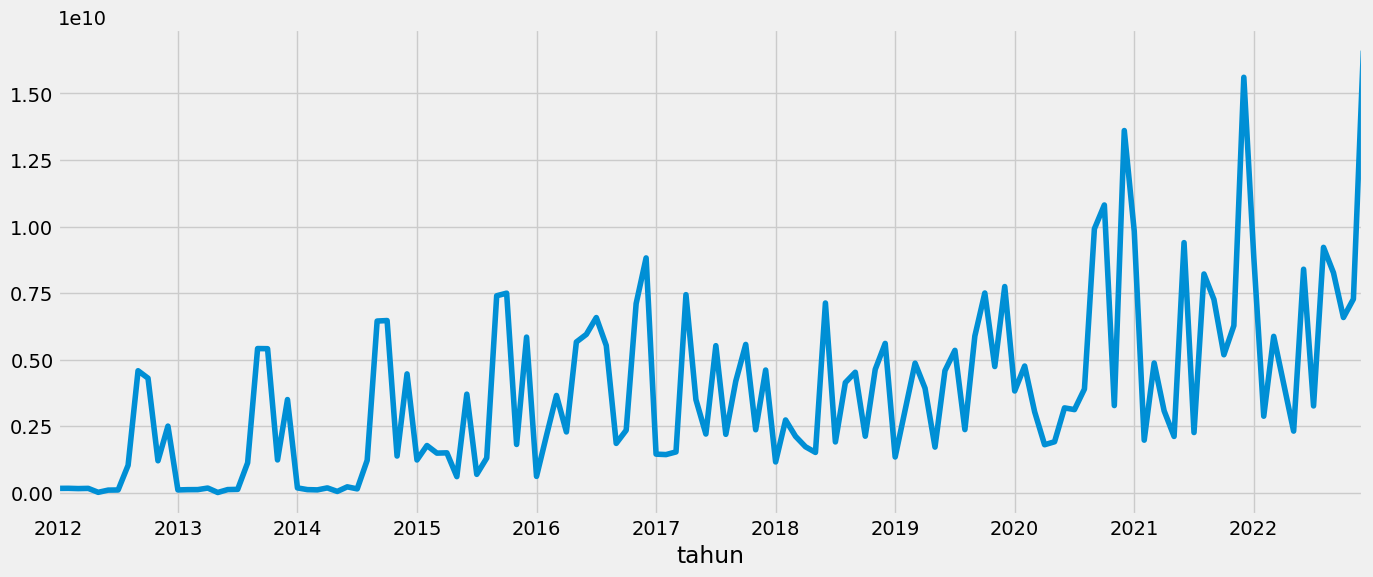

In [5]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [6]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 6)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [81]:
warnings.filterwarnings("ignore")  # specify to ignore warning messages
best_result = [0, 0, 10000000]
p_params = [0, 1, 2, 3]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3]
P_params = [0, 1, 2, 3]
D_params = [0, 1, 2]
Q_params = [0, 1, 2, 3]
for p in p_params:
    for d in d_params:
        for q in q_params:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                        param = [p, d, q]
                        param_seasonal = [P, D, Q, 12]
                        try:
                            mod = sm.tsa.statespace.SARIMAX(dts, order=param, seasonal_order=param_seasonal)
                            results = mod.fit()
                            if results.aic < best_result[2]:
                                if results.aic > 300:
                                    best_result = [param, param_seasonal, results.aic]
                                    print('Best Result:', best_result)
                        except:
                            continue
print('\nBest Result:', best_result)


Best Result: [[0, 0, 0], [0, 0, 1, 12], 6232.142682182863]
Best Result: [[0, 0, 0], [0, 0, 3, 12], 6179.056712891346]
Best Result: [[0, 0, 0], [0, 1, 1, 12], 5535.664417987202]
Best Result: [[0, 0, 0], [0, 1, 2, 12], 5532.055861506916]
Best Result: [[0, 0, 0], [0, 2, 1, 12], 5031.860051236611]
Best Result: [[0, 0, 0], [0, 2, 2, 12], 5020.662878687465]


In [7]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [7]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(2, 1, 1),seasonal_order=(0, 2, 1, 12))
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(0, 2, 1, 12)   Log Likelihood               -2504.043
Date:                            Thu, 30 Mar 2023   AIC                           5018.087
Time:                                    14:20:40   BIC                           5031.451
Sample:                                01-01-2012   HQIC                          5023.504
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0407      0.230     -0.177      0.860      -0.491       0.410
ar.L2         -0.2753      0.258   

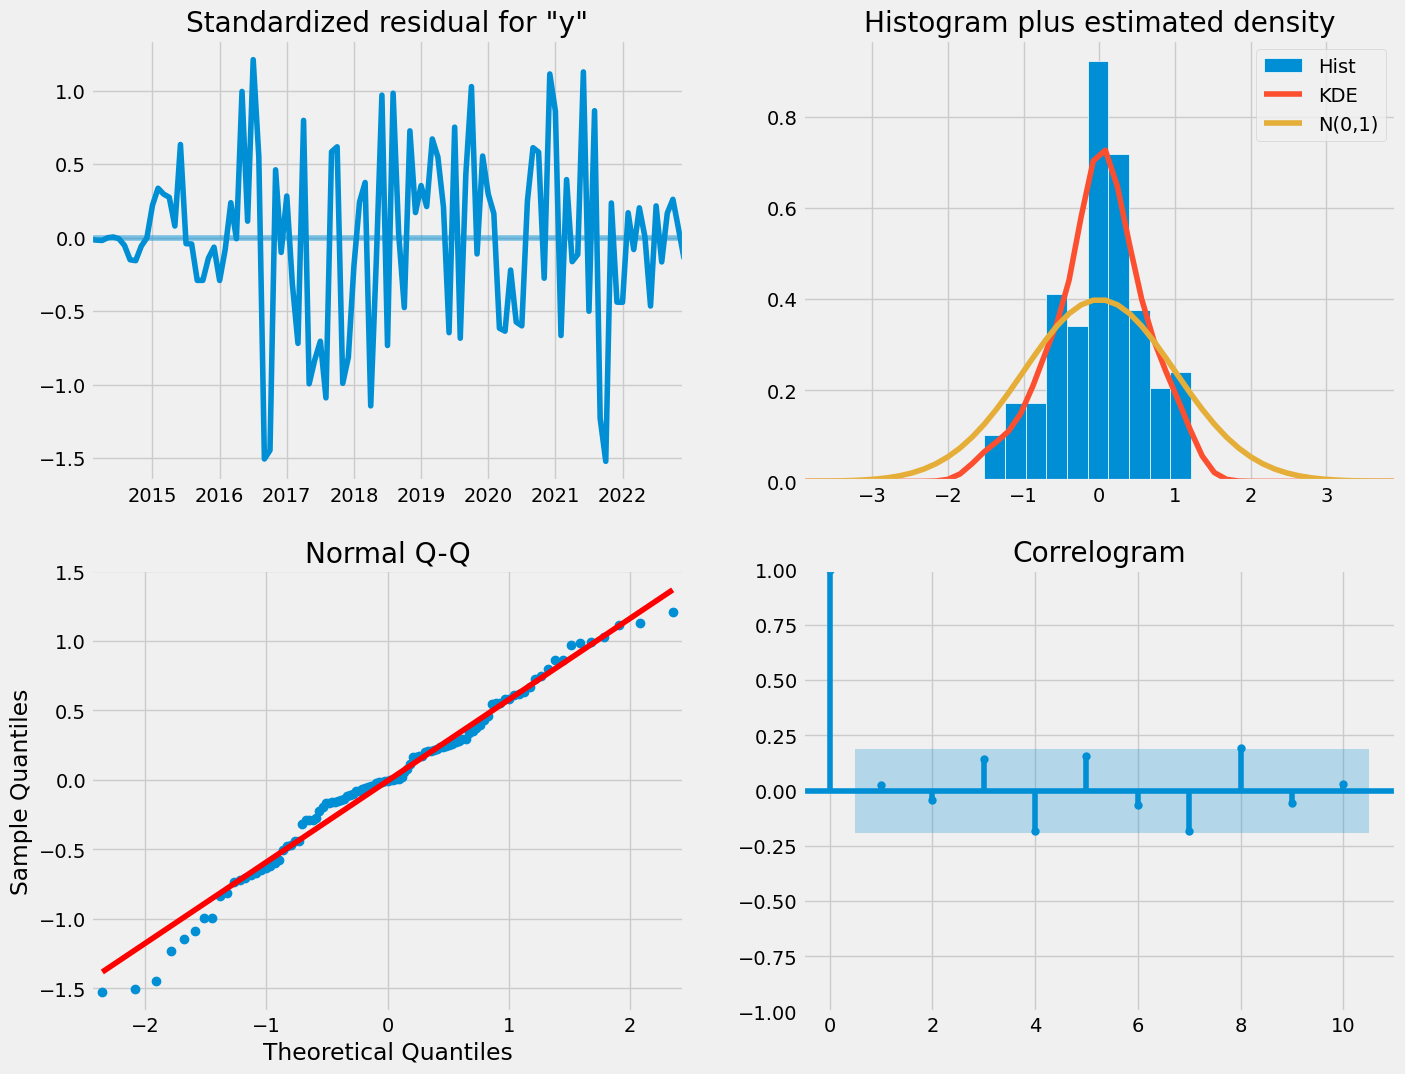

In [8]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

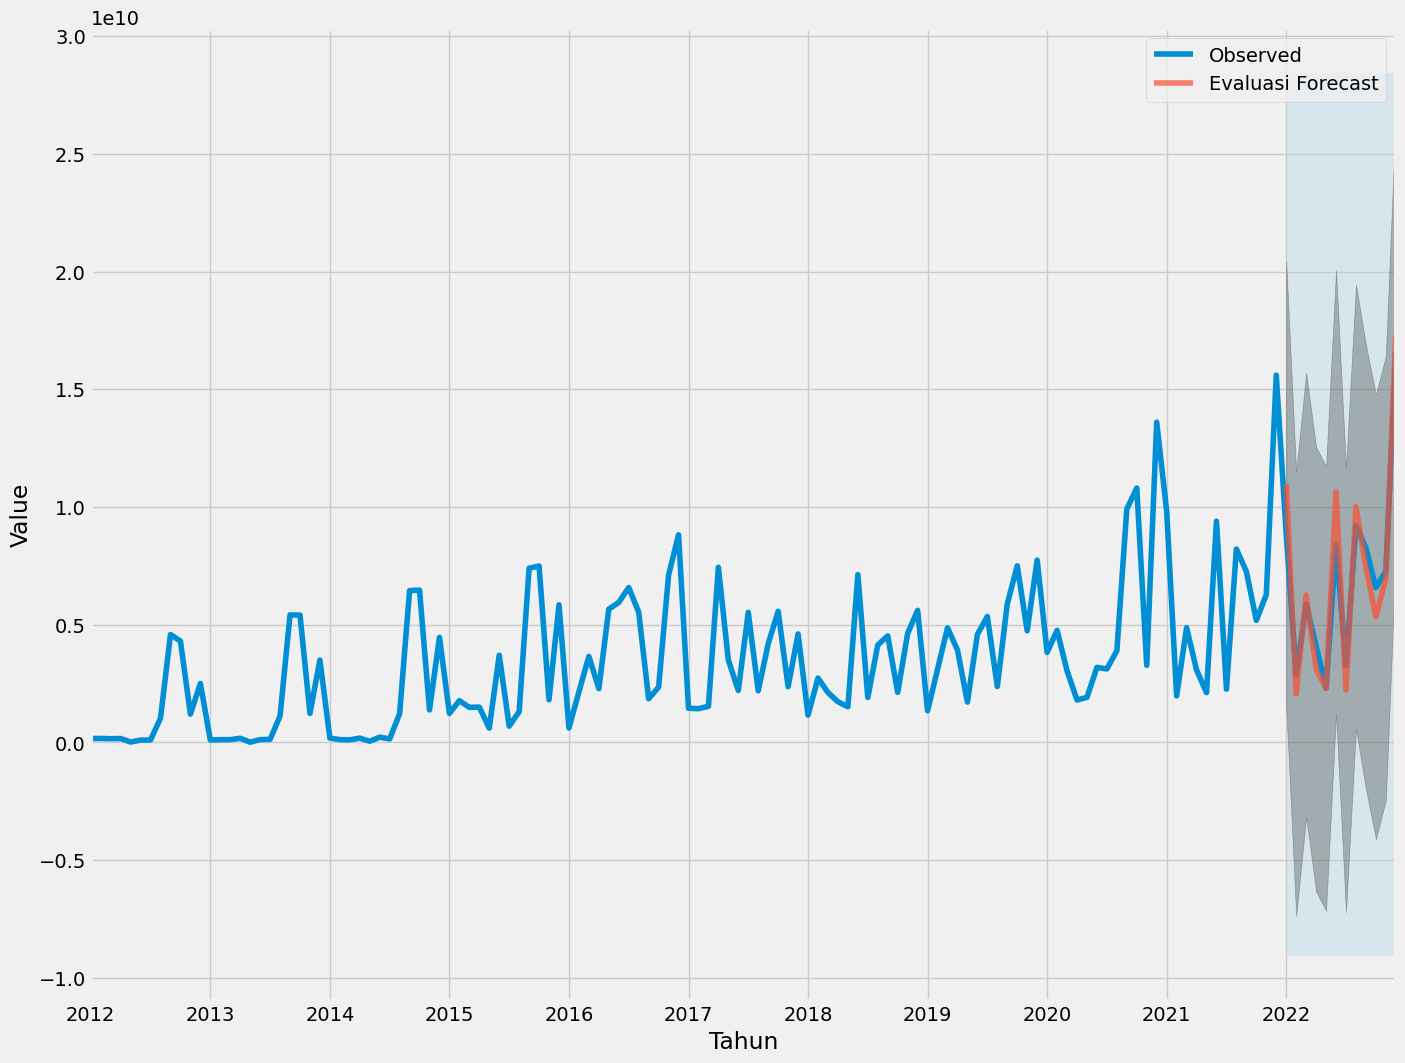

{"2022-01-01T00:00:00.000":10980137609.4063167572,"2022-02-01T00:00:00.000":2064001867.0391759872,"2022-03-01T00:00:00.000":6269277577.720457077,"2022-04-01T00:00:00.000":3115188614.6080374718,"2022-05-01T00:00:00.000":2291968344.2140350342,"2022-06-01T00:00:00.000":10640721429.3976020813,"2022-07-01T00:00:00.000":2225196447.4865646362,"2022-08-01T00:00:00.000":10018544079.1481170654,"2022-09-01T00:00:00.000":7462631059.2850446701,"2022-10-01T00:00:00.000":5331757386.2306699753,"2022-11-01T00:00:00.000":6986393727.6114358902,"2022-12-01T00:00:00.000":17306474647.2340316772}


In [9]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'))
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()


json_data = pred.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/bphtb_predicted_ahead.json', 'w') as f:
    json.dump(json_data, f)

In [10]:
df_test = df[df.tahun.between('2022-01', '2022-12')]
dts_test = pd.Series(data=df_test['jml_setor'].values, index=df_test['tahun'])
y_test, pred_ahead = np.array(dts_test), np.array(pred.predicted_mean)
list_ape = []
for index, elem in np.ndenumerate(pred_ahead):
    ape = np.abs(elem-y_test[index]) / y_test[index]
    list_ape.append(ape*100)
mape = np.mean(list_ape)
print(list_ape)
print(mape)

[23.956265657301977, 28.28962509832973, 6.662681051303182, 23.853088325674708, 1.1133680919481488, 26.699108225068795, 31.843326020855717, 8.656942273389744, 9.712927604665436, 19.038682692257012, 4.003202816643589, 4.207652504354005]
15.669739196815998


# Prediksi data selama 2 tahun

In [12]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=24, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()
json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/bphtb_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2023-01-01T00:00:00.000":10152268665.6207122803,"2023-02-01T00:00:00.000":3461159547.7875981331,"2023-03-01T00:00:00.000":6665438150.4883050919,"2023-04-01T00:00:00.000":4526705268.840256691,"2023-05-01T00:00:00.000":2605753469.0636854172,"2023-06-01T00:00:00.000":9388685743.2880134583,"2023-07-01T00:00:00.000":3553275966.7940626144,"2023-08-01T00:00:00.000":10482684140.6770744324,"2023-09-01T00:00:00.000":9014062100.7722396851,"2023-10-01T00:00:00.000":7046857865.9096870422,"2023-11-01T00:00:00.000":8169548088.7994384766,"2023-12-01T00:00:00.000":18427691035.8807563782,"2024-01-01T00:00:00.000":11500335239.819606781,"2024-02-01T00:00:00.000":3873590810.2240009308,"2024-03-01T00:00:00.000":7502753229.6493635178,"2024-04-01T00:00:00.000":5064741337.1115427017,"2024-05-01T00:00:00.000":2933372349.6483082771,"2024-06-01T00:00:00.000":10406605103.350271225,"2024-07-01T00:00:00.000":3887130469.411087513,"2024-08-01T00:00:00.000":11793005831.5211925507,"2024-09-01T00:00:00.000":9805666392.

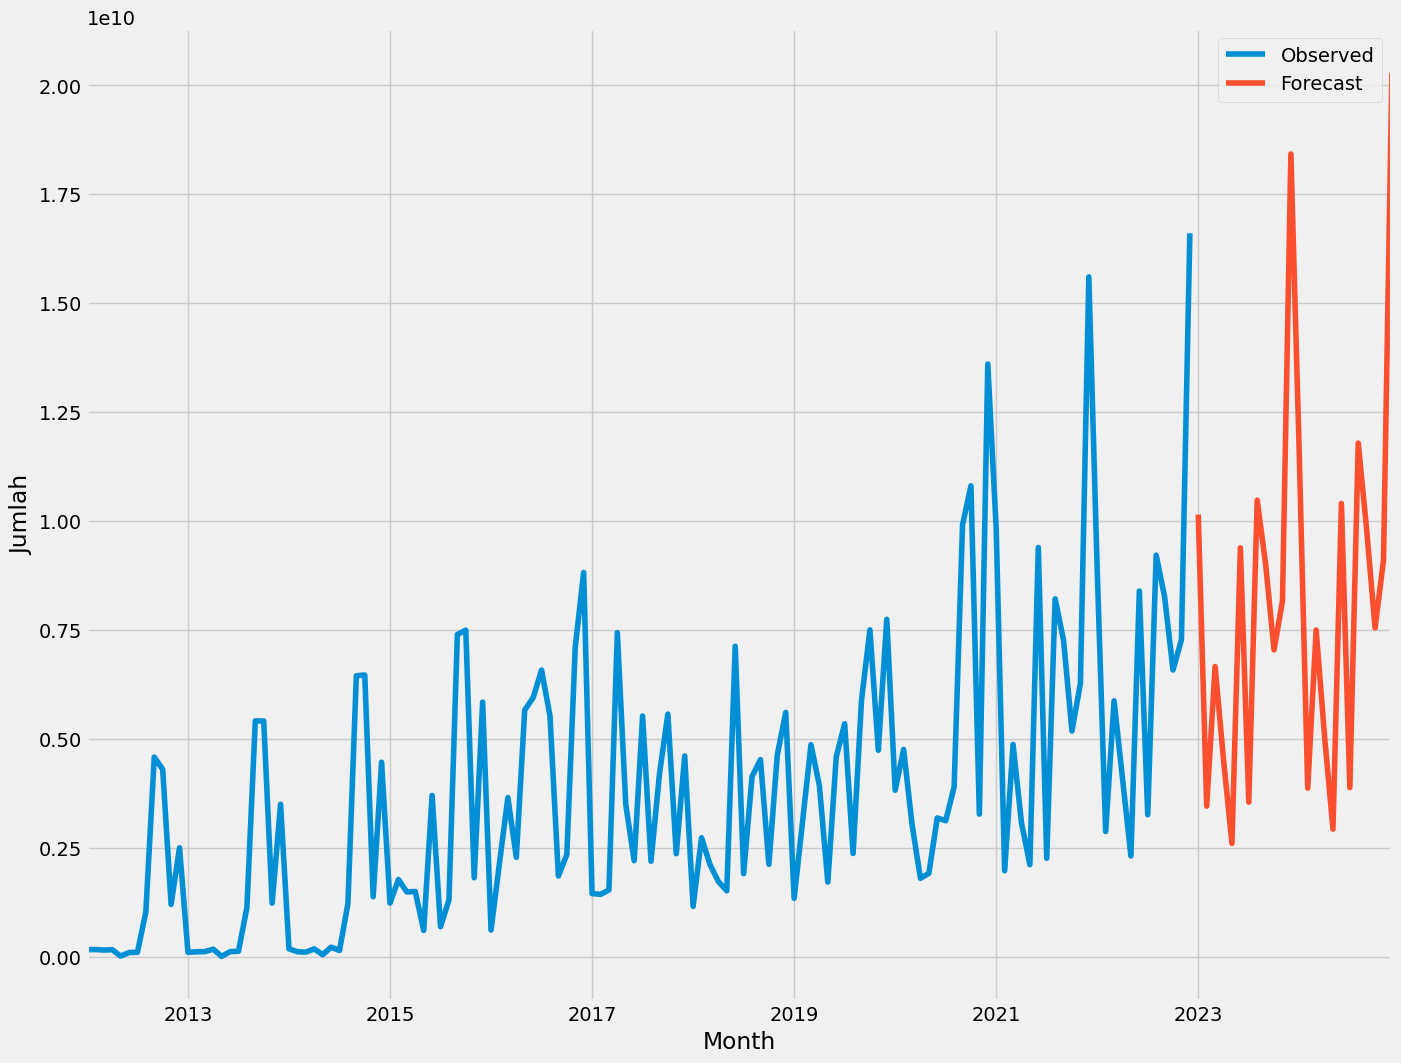

In [13]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()